WAQI - World Air Quality Index 
====

## Libraries

In [1]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import overpy
import shapely
import geojsonio as gjs
import json
import ipyleaflet as ipy
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon 
from descartes import PolygonPatch 
from IPython.display import IFrame 

In [2]:
ox.config(log_console=True, use_cache=True)

## Data

### Covid WAQI Data

In [2]:
'''
waqi_2015H1 = pd.read_csv('../WAQI/waqi-covid-2015H1.csv',sep=',', comment='#')
waqi_2016H1 = pd.read_csv('../WAQI/waqi-covid-2016H1.csv',sep=',', comment='#')
waqi_2017H1 = pd.read_csv('../WAQI/waqi-covid-2017H1.csv',sep=',', comment='#')
waqi_2018H1 = pd.read_csv('../WAQI/waqi-covid-2018H1.csv',sep=',', comment='#')
waqi_2019Q1 = pd.read_csv('../WAQI/waqi-covid-2019Q1.csv',sep=',', comment='#')
waqi_2019Q2 = pd.read_csv('../WAQI/waqi-covid-2019Q2.csv',sep=',', comment='#')
waqi_2019Q3 = pd.read_csv('../WAQI/waqi-covid-2019Q3.csv',sep=',', comment='#')
waqi_2019Q4 = pd.read_csv('../WAQI/waqi-covid-2019Q4.csv',sep=',', comment='#')
waqi_2020 = pd.read_csv('../WAQI/waqi-covid-2020.csv',sep=',', comment='#')

waqi_2015H1B = waqi_2015H1[(waqi_2015H1['Country'] == 'ES') & (waqi_2015H1['Specie'] == 'no2')]
waqi_2016H1B = waqi_2016H1[(waqi_2016H1['Country'] == 'ES') & (waqi_2016H1['Specie'] == 'no2')]
waqi_2017H1B = waqi_2017H1[(waqi_2017H1['Country'] == 'ES') & (waqi_2017H1['Specie'] == 'no2')]
waqi_2018H1B = waqi_2018H1[(waqi_2018H1['Country'] == 'ES') & (waqi_2018H1['Specie'] == 'no2')]
waqi_2019Q1B = waqi_2019Q1[(waqi_2019Q1['Country'] == 'ES') & (waqi_2019Q1['Specie'] == 'no2')]
waqi_2019Q2B = waqi_2019Q2[(waqi_2019Q2['Country'] == 'ES') & (waqi_2019Q2['Specie'] == 'no2')]
waqi_2019Q3B = waqi_2019Q3[(waqi_2019Q3['Country'] == 'ES') & (waqi_2019Q3['Specie'] == 'no2')]
waqi_2019Q4B = waqi_2019Q4[(waqi_2019Q4['Country'] == 'ES') & (waqi_2019Q4['Specie'] == 'no2')]
waqi_2020B = waqi_2020[(waqi_2020['Country'] == 'ES') & (waqi_2020['Specie'] == 'no2')]

waqiB = pd.concat([waqi_2015H1B,waqi_2016H1B,waqi_2017H1B,waqi_2018H1B,waqi_2019Q1B,waqi_2019Q2B,waqi_2019Q3B,waqi_2019Q4B,waqi_2020B]).sort_values(by='Date')
waqiB.index = np.arange(1, len(waqiB)+1)
waqiB.head()
'''

### WAQI Data

#### Idea

The datasets information was commented in the first three lines of each file. We decided to combine all the files into one DataFrame, scraping the information of Latitude and Longitude and created a column to populate each row with geographic coordinates.

In [27]:
'''
os.getcwd()

import os
Path = "../waqi/WAQI-1/"
filelist = os.listdir(Path)
location = []
WAQI_all = pd.DataFrame()
for i in filelist:
    if i.endswith(".csv"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'r') as f:
            df = pd.read_csv(Path + i, comment = '#')
            length = len(df)           
            for line in f:
                if line.startswith('#Station'):
                    second_row = line.split(' ')
                    
                    latitude = []
                    lat = [float(second_row[-3][:-1])] * length
                    latitude.extend(lat)                   
                    df['Latitude'] = latitude
                    
                    longitude = []
                    lon = [float(second_row[-1])] * length
                    longitude.extend(lon)
                    df['Longitude'] = longitude
                    
                    WAQI_all = pd.concat([WAQI_all, df], ignore_index=True)

pd.set_option('display.max_columns', None)

WAQI_all = WAQI_all[['date','no2','no2_min','no2_max','Latitude','Longitude']]
WAQI_all.head()

WAQI_all.to_csv(r'../waqi/WAQI_all.csv', index = False)
'''

In [3]:
WAQI_all = pd.read_csv('../waqi/WAQI_all.csv')

gdf_WAQI_all = gpd.GeoDataFrame(WAQI_all, geometry=gpd.points_from_xy(WAQI_all.Longitude, WAQI_all.Latitude))
gdf_WAQI_all = gdf_WAQI_all.drop(['Longitude','Latitude'],axis=1)

gdf_WAQI_all.head()

,date,no2,no2_min,no2_max,geometry
0,2020-05-07,9,9,9,POINT (-5.95849 43.57532)
1,2020-05-06,7.5,2,17,POINT (-5.95849 43.57532)
2,2020-05-05,11.5,3,21,POINT (-5.95849 43.57532)
3,2020-05-04,12,3,29,POINT (-5.95849 43.57532)
4,2020-05-03,3.9,1,15,POINT (-5.95849 43.57532)


### Plot

#### Idea

Import the map of spain from GeoPandas and plot the station points combining with the map.

In [3]:
import geoplot
import mapclassify

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

spain = world[world['name'] == ('Spain')]

<Figure size 2160x1440 with 0 Axes>

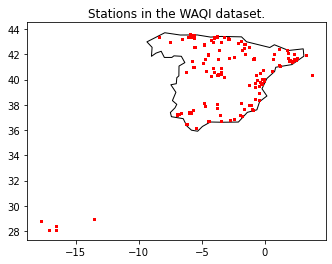

In [10]:
plt.figure(figsize=(30,20))
fig, ax = plt.subplots()
ax.set_aspect('equal')
spain.plot(ax=ax, figsize = (30,20), color='white', edgecolor='black')
gdf_WAQI_all.plot(ax=ax, figsize = (30,20), marker='o', color='red',  markersize=1)
plt.title("Stations in the WAQI dataset.")

plt.show();

### Exporting WAQI.geojson

In [ ]:
'''
gdf_WAQI_all.to_file("../Datasets/gdf_WAQI_all.geojson", driver='GeoJSON')
'''